## Fitting a function with *gradient descent*

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

In [2]:
plt.ylim?

Signature: plt.ylim(*args, **kwargs)
Docstring:
Get or set the y-limits of the current axes.

Call signatures::

    bottom, top = ylim()  # return the current ylim
    ylim((bottom, top))   # set the ylim to bottom, top
    ylim(bottom, top)     # set the ylim to bottom, top

If you do not specify args, you can alternatively pass *bottom* or
*top* as kwargs, i.e.::

    ylim(top=3)  # adjust the top leaving bottom unchanged
    ylim(bottom=1)  # adjust the bottom leaving top unchanged

Setting limits turns autoscaling off for the y-axis.

Returns
-------
bottom, top
    A tuple of the new y-axis limits.

Notes
-----
Calling this function with no arguments (e.g. ``ylim()``) is the pyplot
equivalent of calling `~.Axes.get_ylim` on the current axes.
Calling this function with arguments is the pyplot equivalent of calling
`~.Axes.set_ylim` on the current axes. All arguments are passed though.
File:      /usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py
Type:      function


In [22]:
?torch.linspace

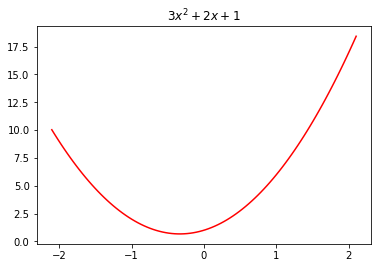

In [5]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [6]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [7]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [11]:
?partial

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
File:           /usr/lib/python3.9/functools.py
Type:           type
Subclasses:     


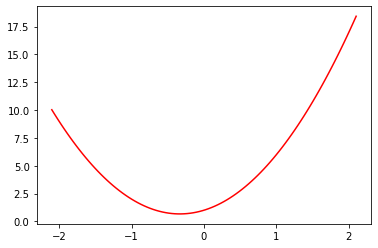

In [8]:
f2 = mk_quad(3,2,1)
plot_function(f2)

In [24]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [9]:
?np.random.normal

Docstring:
normal(loc=0.0, scale=1.0, size=None)

Draw random samples from a normal (Gaussian) distribution.

The probability density function of the normal distribution, first
derived by De Moivre and 200 years later by both Gauss and Laplace
independently [2]_, is often called the bell curve because of
its characteristic shape (see the example below).

The normal distributions occurs often in nature.  For example, it
describes the commonly occurring distribution of samples influenced
by a large number of tiny, random disturbances, each with its own
unique distribution [2]_.

.. note::
    New code should use the ``normal`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
loc : float or array_like of floats
    Mean ("centre") of the distribution.
scale : float or array_like of floats
    Standard deviation (spread or "width") of the distribution. Must be
    non-negative.
size : int or tuple of ints, optional
    Out

In [39]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)#[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [40]:
x.shape?

In [41]:
x[:5],y[:5]

(tensor([-2.0000, -1.7895, -1.5789, -1.3684, -1.1579]),
 tensor([11.8690,  6.5433,  5.9396,  2.6304,  1.7947], dtype=torch.float64))

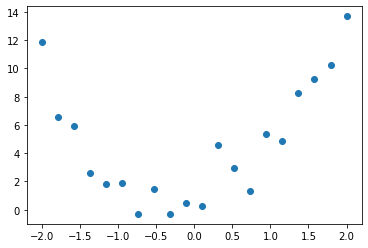

In [42]:
plt.scatter(x,y);

In [43]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [44]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [45]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automating gradient descent

In [60]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [61]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

In [62]:
abc = torch.tensor([1.1,1.1,1.1])

In [63]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [64]:
abc.requires_grad_?

In [65]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [66]:
loss.backward()

In [67]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

In [68]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=2.40


In [69]:
torch.no_grad?

In [54]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


In [75]:
loss.backward?

## How a neural network approximates any given function

In [77]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

In [80]:
torch.clamp?

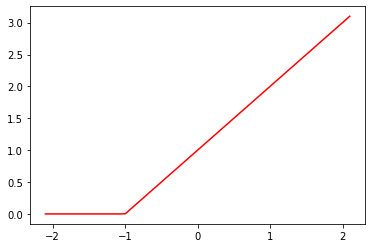

In [56]:
plot_function(partial(rectified_linear, 1,1))

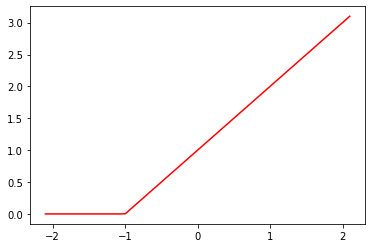

In [57]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

In [58]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [59]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

## How to recognise an owl